In [1]:
%load_ext autoreload
%autoreload 2
import torch
import yaml
import logging
from imp import reload
import matplotlib.pyplot as plt
import yaml
import numpy as np
import cv2
import os
from tqdm import tqdm
from load import *
tqdm.get_lock().locks = []
reload(logging)
logger = logging.getLogger(__name__).setLevel(logging.INFO)


In [7]:
# decleare data parameters
# out 00 -> without bln, 0.004
par_train = {'data_dir'   : '', # change the path 
       'out_dir'          : './out_across_undistort_bln_dropout/',
       'train_session_id' : [1,2,3],
       'test_session_id'  : [0],
       'test_cam_id'      : [3]}

# merge with training parameters
par_data = yaml.full_load(open('param.yaml', "rb"))
par = {**par_data["data"], **par_train}

#meta = mat73.loadmat('nolj_Recording_day8_caff1_nolj_imputed.mat')
# naming scheme used in the capture dataset for different cameras
cam_list = np.array(['R', 'L', 'E', 'U', 'S', 'U2'])

bone_length = {(0, 3): 80.98554459477106,
                 (3, 5): 112.90207543313412,
                 (5, 8): 28.733636975647393,
                 (5, 9): 34.84953102842617,
                 (10, 11): 15.956945352305892,
                 (3, 12): 29.946991312076776,
                 (3, 13): 19.409450872458986,
                 (10, 12): 40.857306953944935,
                 (13, 14): 37.08634981412786,
                 (14, 15): 20.954239695086592,
                 (8, 17): 35.39218881579121,
                 (9, 16): 25.59466626887338,
                 (17, 18): 31.033650232299784,
                 (16, 19): 25.244471236727712}

In [5]:
import scipy.io
from load import world_to_camera2, get_btch
from liftpose.vision_3d import normalize_bone_length


train_2d, train_3d, test_2d, test_3d = list(), list(), list(), list()
for s in par_train["train_session_id"]:
    tr2d, tr3d = get_btch(s, cam_list, par, par_data, bone_length)
    train_2d.extend(tr2d)
    train_3d.extend(tr3d)
    
for s in par_train["test_session_id"]:
    te2d, te3d = get_btch(s, cam_list[par_train["test_cam_id"]], par, par_data, bone_length)
    test_2d.extend([t for t in te2d])
    test_3d.extend([t for t in te3d])

train_2d = np.concatenate(train_2d, axis=0)
train_3d = np.concatenate(train_3d, axis=0)
test_2d = np.concatenate(test_2d, axis=0)
test_3d = np.concatenate(test_3d, axis=0)
train_keypoints = np.logical_not(np.isnan(train_3d))
test_keypoints = np.logical_not(np.isnan(test_3d))

# if more than one third is missing remove it
train_keypoints[np.sum(np.logical_not(train_keypoints), axis=(1,2)) > 20] = False
test_keypoints[np.sum(np.logical_not(test_keypoints), axis=(1,2)) > 20] = False

# if the root is none, then ignore that point, otherwise we cannot anchor
train_keypoints[np.any(np.isnan(train_2d[:,3]),axis=-1)] = False
test_keypoints[np.any(np.isnan(test_2d[:,3]),axis=-1)] = False

# impute nan's with zeros. zero 3d points will not be counted towards loss.
#train_2d[np.isnan(train_2d)] = 0
# randomly drop some 2d points, to create 
#drop_ind = np.random.rand(train_2d.shape[0], train_2d.shape[1]) > 0.95
#print(np.sum(drop_ind))
#train_2d[drop_ind] = np.nan

#train_3d[np.isnan(train_3d)] = 0
#test_2d[np.isnan(test_2d)] = 0
#test_3d[np.isnan(test_3d)] = 0

In [6]:
from sklearn.model_selection import train_test_split
from liftpose.main import train_np

train_np(train_2d=train_2d, test_2d=test_2d,
         train_3d=train_3d, test_3d=test_3d,
         out_dir=par['out_dir'], root=par['roots'][0],
         train_keypts=train_keypoints, test_keypts=test_keypoints, training_kwargs={"epochs":100, "lr_decay": 50000, "lr_gamma": 0.95, "dropout":0.1})

[main.py:252]:INFO:Saving pre-processed 2D data at /home/user/Desktop/LiftPose3D/examples/capture/out_across_undistort_bln_dropout/stat_2d.pth.tar.
[main.py:271]:INFO:Saving pre-processed 3D data at /home/user/Desktop/LiftPose3D/examples/capture/out_across_undistort_bln_dropout/stat_3d.pth.tar.
[main.py:298]:INFO:Starting training model.
[main.py:308]:DEBUG:
==================Options=================
[main.py:309]:DEBUG:{   'batch_size': 64,
    'data_dir': '/home/user/Desktop/LiftPose3D/examples/capture/out_across_undistort_bln_dropout',
    'drop_input': 0.0,
    'dropout': 0.1,
    'epochs': 100,
    'exp': '',
    'is_train': True,
    'job': 8,
    'linear_size': 1024,
    'load': None,
    'lr': 0.001,
    'lr_decay': 50000,
    'lr_gamma': 0.95,
    'max_norm': True,
    'noise': None,
    'num_stage': 2,
    'out': '/home/user/Desktop/LiftPose3D/examples/capture/out_across_undistort_bln_dropout',
    'out_dir': '/home/user/Desktop/LiftPose3D/examples/capture/out_across_undistor

Epoch 000 | LR  0.00100 | Loss Test  0.00000 | Loss Train  0.06937|: 100%|██████████| 15188/15188 [03:34<00:00, 70.95it/s]
Epoch 001 | LR  0.00100 | Loss Test  0.07286 | Loss Train  0.03342|: 100%|██████████| 15188/15188 [03:31<00:00, 71.69it/s]
Epoch 002 | LR  0.00100 | Loss Test  0.06650 | Loss Train  0.02876|:   6%|▌         | 883/15188 [00:13<03:37, 65.74it/s]


KeyboardInterrupt: 

[main.py:409]:INFO:starting testing in path: ./out_across_undistort_bln_dropout/
[lift.py:31]:INFO:Training on the device: cuda:0
[lift.py:60]:INFO:total params: 4.31M
[lift.py:66]:INFO:loading ckpt from './out_across_undistort_bln_dropout/ckpt_best.pth.tar'
[lift.py:74]:INFO:ckpt loaded (epoch: 2 | err: 3.605576077893017)
[lift.py:110]:INFO:Saving results: /home/user/Desktop/LiftPose3D/examples/capture/out_across_undistort_bln_dropout/test_results.pth.tar
(54000, 20, 3)


Text(0, 0.5, 'Percentage of body length (%)')

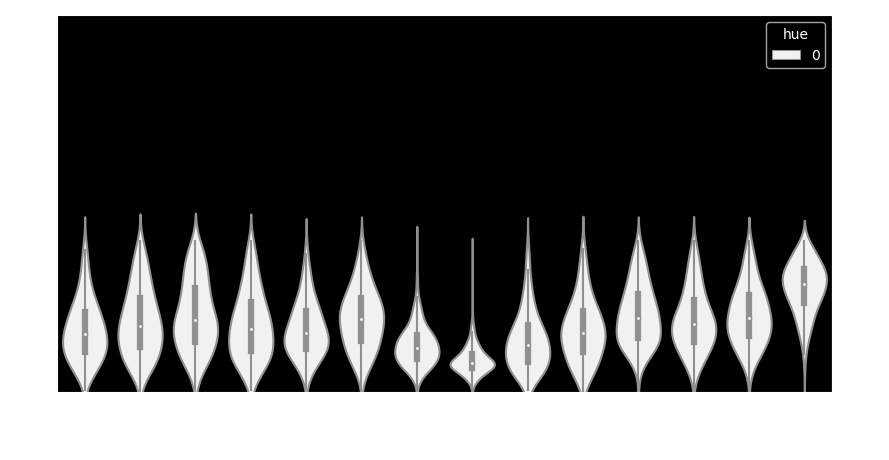

In [8]:
from liftpose.postprocess import load_test_results
from liftpose.main import test as lp3d_test
plt.style.use('dark_background')

lp3d_test(par['out_dir'])
data = torch.load(os.path.join(par['out_dir'], "test_results.pth.tar"))
stat_2d, stat_3d = (
    torch.load(os.path.join(par['out_dir'], "stat_2d.pth.tar")),
    torch.load(os.path.join(par['out_dir'], "stat_3d.pth.tar")),
)
test_3d_gt, test_3d_pred, good_keypts = load_test_results(data, stat_2d, stat_3d)
test_3d_gt[np.logical_not(good_keypts.reshape(-1, 20, 3))] = np.nan
test_3d_gt[:, 3] = test_3d_pred[:, 3]
print(test_3d_gt.shape)
%matplotlib inline
from liftpose.plot import violin_plot
order = ['HeadF', 'SpineL', 'HipL', 'HipR', 'ElbowL', 'ArmL', 'ShoulderL', 'ShoulderR', 'ElbowR', 'ArmR', 'KneeR', 'KneeL', 'ShinL', 'ShinR']
plt.figure(figsize=(10,5), dpi=100)
names = par_data["vis"]["names"]
names = [n[0] for n in names]
ax = plt.gca()
violin_plot(ax, test_3d_gt, test_3d_pred, good_keypts, joints_name=names,units='mm', order=order)
plt.ylim([0,35])

y = ax.secondary_yaxis('right', functions=(lambda x: x*100/263.67, lambda x: x*100/263.67))
y.set_ylabel(r'Percentage of body length (%)')

[main.py:409]:INFO:starting testing in path: out_across_undistort_bln
[lift.py:31]:INFO:Training on the device: cuda:0
[lift.py:60]:INFO:total params: 4.31M
[lift.py:66]:INFO:loading ckpt from 'out_across_undistort_bln/ckpt_best.pth.tar'
[lift.py:74]:INFO:ckpt loaded (epoch: 62 | err: 3.7535530310616707)
[lift.py:110]:INFO:Saving results: /home/user/Desktop/LiftPose3D/examples/capture/out_across_undistort_bln/test_results.pth.tar
(12000, 20, 3)


Text(0, 0.5, 'Percentage of body length (%)')

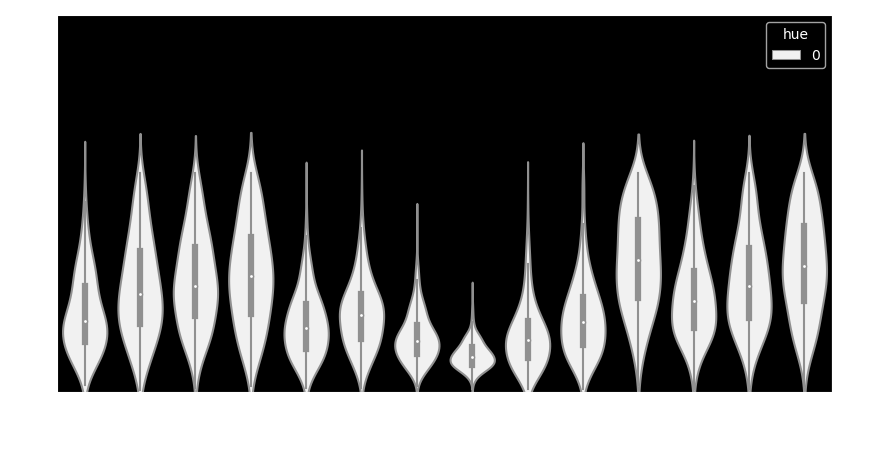

In [9]:
from liftpose.postprocess import load_test_results
from liftpose.main import test as lp3d_test
plt.style.use('dark_background')
par['out_dir'] = 'out_across_undistort_bln'
lp3d_test(par['out_dir'])
data = torch.load(os.path.join(par['out_dir'], "test_results.pth.tar"))
stat_2d, stat_3d = (
    torch.load(os.path.join(par['out_dir'], "stat_2d.pth.tar")),
    torch.load(os.path.join(par['out_dir'], "stat_3d.pth.tar")),
)
test_3d_gt, test_3d_pred, good_keypts = load_test_results(data, stat_2d, stat_3d)
test_3d_gt[np.logical_not(good_keypts.reshape(-1, 20, 3))] = np.nan
test_3d_gt[:, 3] = test_3d_pred[:, 3]
print(test_3d_gt.shape)
%matplotlib inline
from liftpose.plot import violin_plot
order = ['HeadF', 'SpineL', 'HipL', 'HipR', 'ElbowL', 'ArmL', 'ShoulderL', 'ShoulderR', 'ElbowR', 'ArmR', 'KneeR', 'KneeL', 'ShinL', 'ShinR']
plt.figure(figsize=(10,5), dpi=100)
names = par_data["vis"]["names"]
names = [n[0] for n in names]
ax = plt.gca()
violin_plot(ax, test_3d_gt, test_3d_pred, good_keypts, joints_name=names,units='mm', order=order)
plt.ylim([0,35])

y = ax.secondary_yaxis('right', functions=(lambda x: x*100/263.67, lambda x: x*100/263.67))
y.set_ylabel(r'Percentage of body length (%)')

In [ ]:
from liftpose.postprocess import load_test_results
from liftpose.main import test as lp3d_test
plt.style.use('dark_background')

lp3d_test(par['out_dir'])
data = torch.load(os.path.join(par['out_dir'], "test_results.pth.tar"))
stat_2d, stat_3d = (
    torch.load(os.path.join(par['out_dir'], "stat_2d.pth.tar")),
    torch.load(os.path.join(par['out_dir'], "stat_3d.pth.tar")),
)
test_3d_gt, test_3d_pred, good_keypts = load_test_results(data, stat_2d, stat_3d)
test_3d_gt[np.logical_not(good_keypts.reshape(-1, 20, 3))] = np.nan
test_3d_gt[:, 3] = test_3d_pred[:, 3]

%matplotlib inline
from liftpose.plot import violin_plot
order = ['HeadF', 'SpineL', 'HipL', 'HipR', 'ElbowL', 'ArmL', 'ShoulderL', 'ShoulderR', 'ElbowR', 'ArmR', 'KneeR', 'KneeL', 'ShinL', 'ShinR']
plt.figure(figsize=(10,5), dpi=100)
names = par_data["vis"]["names"]
names = [n[0] for n in names]
ax = plt.gca()
violin_plot(ax, test_3d_gt, test_3d_pred, good_keypts, joints_name=names,units='mm', order=order)
plt.ylim([0,35])

y = ax.secondary_yaxis('right', functions=(lambda x: x*100/263.67, lambda x: x*100/263.67))
y.set_ylabel(r'Percentage of body length (%)')

In [ ]:
from liftpose.postprocess import load_test_results
from liftpose.main import test as lp3d_test
plt.style.use('dark_background')

lp3d_test(par['out_dir'])
data = torch.load(os.path.join(par['out_dir'], "test_results.pth.tar"))
stat_2d, stat_3d = (
    torch.load(os.path.join(par['out_dir'], "stat_2d.pth.tar")),
    torch.load(os.path.join(par['out_dir'], "stat_3d.pth.tar")),
)
test_3d_gt, test_3d_pred, good_keypts = load_test_results(data, stat_2d, stat_3d)
test_3d_gt[np.logical_not(good_keypts.reshape(-1, 20, 3))] = np.nan
test_3d_gt[:, 3] = test_3d_pred[:, 3]

%matplotlib inline
from liftpose.plot import violin_plot
order = ['HeadF', 'SpineL', 'HipL', 'HipR', 'ElbowL', 'ArmL', 'ShoulderL', 'ShoulderR', 'ElbowR', 'ArmR', 'KneeR', 'KneeL', 'ShinL', 'ShinR']
plt.figure(figsize=(10,5), dpi=100)
names = par_data["vis"]["names"]
names = [n[0] for n in names]
ax = plt.gca()
violin_plot(ax, test_3d_gt, test_3d_pred, good_keypts, joints_name=names,units='mm', order=order)
plt.ylim([0,35])

y = ax.secondary_yaxis('right', functions=(lambda x: x*100/263.67, lambda x: x*100/263.67))
y.set_ylabel(r'Percentage of body length (%)')

In [92]:
from liftpose.vision_3d import calculate_bone_length, normalize_bone_length
c = calculate_bone_length(test_3d, par_data["vis"]["bones"])
bone_length = np.nanmean(c, axis=0)
print(np.nanstd(c[:,6]))
bone_length = {tuple(k):v for (k,v) in zip(par_data['vis']["bones"], bone_length)}
pose_3d_norm = normalize_bone_length(test_3d.copy(), root=par["roots"][0], child=par_data["vis"]["child"], bone_length=bone_length, thr=10)
c = calculate_bone_length(pose_3d_norm,par_data["vis"]["bones"])
print(np.nanstd(c[:,9]))

6.438864666005551
4.6337833760451254e-14


/home/user/Desktop/LiftPose3D/liftpose/vision_3d.py:49: RuntimeWarning: invalid value encountered in less
  print(offset.shape, curr_length.shape)


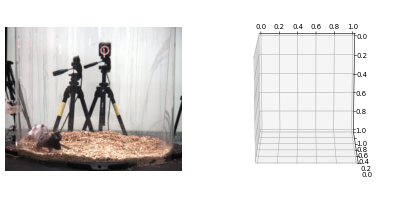

In [88]:
from celluloid import Camera
from load import read_data
from liftpose.plot import plot_pose_3d
import matplotlib.gridspec as gridspec
from load import plot_pose_2d
%matplotlib inline

session_id = 0

mat = [read_data(session_id, cid) for (cid,_) in enumerate(cam_list)]
fig = plt.figure(figsize=(10,5), dpi=50)

ax_2d = fig.add_subplot(121)
ax_3d = fig.add_subplot(122, projection='3d')
ax_3d.view_init(-75, -90)
ax_2d.axis('off')

for idx, frame_id in enumerate(range(0,200)):
    ax_2d = plot_pose_2d(frame_id, cam_id=0, ax=ax_2d, mat=mat, cam_list=cam_list)
    plot_pose_3d(ax=ax_3d, tar=test_3d[frame_id].copy(),
                 bones=par_data["vis"]["bones"], 
                 limb_id=par_data["vis"]["limb_id"], 
                 colors=par_data["vis"]["colors"], 
                 normalize=False, show_pred_always=True)

    origin = test_3d[frame_id][3]# if np.isnan(test_3d_gt[frame_id][3][0]) else [0,0,0]
    ax_3d.set_xbound(origin[0]-100, origin[0]+100)
    ax_3d.set_ylim(0,150)
    ax_3d.set_zlim(origin[2]-100, origin[2]+100)
    
    plt.savefig(f'out_single_animal_missing_left/im{frame_id}.jpg')
    ax_3d.clear()
    #cam.snap()
#cam.animate().save('test_marker.mp4')

In [89]:
!ffmpeg -loglevel panic -start_number 0 -i out_single_animal_missing_left/im%d.jpg  -pix_fmt yuv420p out.mp4 -y
from IPython.display import Video
Video("out.mp4")